<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/SIADS695_clock_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project is inspired by the AI Crowd Challenge: https://www.aicrowd.com/challenges/addi-alzheimers-detection-challenge

Data from NHATs: https://nhats.org/researcher/data-access


Meta file crosswalk: https://www.nhats.org/sites/default/files/2021-07/NHATS_R10_Final_Crosswalk_between_Instruments_and_Codebook.pdf

User Guide: https://www.nhats.org/sites/default/files/2021-07/NHATS_User_Guide_R10_Final_Release.pdf

In [ ]:
# contains all the clock images for round 1.  arn:aws:s3:::clockdrawingimages1
# URL of a single clock image from round 1 (not all image file names increment by 1): https://clockdrawingimages1.s3.us-west-1.amazonaws.com/10000003.tif
# URI of a single clock image from round 1: s3://clockdrawingimages1/10000003.tif

# URL of a single clock image from round 2 (not all image file names increment by 1):https://clockdrawingimages2.s3.us-west-1.amazonaws.com/10000003.tif


# URL of a single clock image from round 2 (not all image file names increment by 1): https://clockdrawingimages3.s3.us-west-1.amazonaws.com/10000003.tif

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from io import BytesIO
import requests
from PIL import Image



In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
!ls

fatal: destination path 'MADSmilestone2' already exists and is not an empty directory.
/content/MADSmilestone2
ian_testingground.ipynb  load_data.py  README.md  SIADS695_clock_image.ipynb


In [ ]:
import load_data
#load_data.load_data()
load_data.load_images()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [54]:
def load_data():
  """Load stata data from S3, rounds 1 - 10; contains diagnoses, scoring, subject ID to map to images
  hc1disescn9 : 1 - YES to dementia/Alzheimers, 2 - NO Dementia, may want to drop -9 and -1?, may need to relabel 7. 
  cg1dclkdraw: score of drawing
  spid: Subject ID, number maps to number in image file names"""

  values = [1, 2, 3, 4]#, 5, 6, 7, 8, 9, 10] 
  round_data = pd.DataFrame()

  for val in values:
    data = pd.io.stata.read_stata('https://clockdrawingbattery.s3.us-west-1.amazonaws.com/NHATS_Round_'+str(val)+'_SP_File.dta')
    data = data[['spid','cg'+str(val)+'dclkdraw', 'hc'+str(val)+'disescn9']]
    data['round'] = val

    # Rename columns
    data.rename(columns={'cg'+str(val)+'dclkdraw': 'cg'+str(int(val/val))+'dclkdraw', 'hc'+str(val)+'disescn9': 'hc'+str(int(val/val))+'disescn9'}, inplace = True)
    round_data = round_data.append(data)
  
 
  return round_data





rounds_df = load_data()

In [57]:
print("Column values for clock scores: \n", rounds_df['cg1dclkdraw'].unique())
print("\nHealth score values: \n", rounds_df['hc1disescn9'].unique())
print("\nVariable types: \n", rounds_df.dtypes)
rounds_df[rounds_df['cg1dclkdraw'] == '-1 Inapplicable'].head()

Column values for clock scores: 
 ['3 Mildly distorted depiction of a clock', '4 Reasonably accurate depiction of a clock', '2 Moderately distorted depection of a clock', '5 Accurate depiction of a clock (circular or ..., '1 Severely distorted depiction of a clock', '0 Not recognizable as a clock']
Categories (6, object): ['0 Not recognizable as a clock' < '1 Severely distorted depiction of a clock' <
                         '2 Moderately distorted depection of a clock' < '3 Mildly distorted depiction of a clock' <
                         '4 Reasonably accurate depiction of a clock' < '5 Accurate depiction of a clock (circular or ...]

Health score values: 
 [2. 1. 7.]

Variable types: 
 spid             string
cg1dclkdraw    category
hc1disescn9     float64
round             int64
dtype: object


,spid,cg1dclkdraw,hc1disescn9,round


In [56]:
def clean_data(rounds_df):
  # Clean the row values in hc1disescn9 , cg1dclkdraw
  # hc1disescn9 asks if subject has dementia or alzheimers: 1 YES, 2 NO

  df = rounds_df
  hc_items = [('2 NO', 2),(' 2 NO', 2), ('1 YES', 1),(' 1 YES', 1),
              ('-9 Missing', np.nan),('-8 DK', np.nan),('7 PREVIOUSLY REPORTED', 7),
              ('-1 Inapplicable', np.nan),('-7 RF', np.nan)]

  cg_items = [('-2 Proxy says cannot ask SP', np.nan), ('-7 SP refused to draw clock', np.nan), 
              ('-4 SP did not attempt to draw clock', np.nan), ('-3 Proxy says can ask SP but SP unable to answer', np.nan), 
              ('-1 Inapplicable', np.nan), ('-9 Missing', np.nan)]

  for item in hc_items:
    df.hc1disescn9.replace(item[0], item[1], inplace = True)

  # Remove cg1dclkdraw subjects that did not draw a clock, or image data is missing
  for item in cg_items:
    df.cg1dclkdraw.replace(item[0], item[1], inplace = True)

  
  # Drop all NaN
  df.dropna(inplace = True)

  # Change IDs to string value for streaming images
  df['spid'] = df['spid'].astype('string')

  # Keep just the 8 digit value in spid, removing float value
  df['spid']= df['spid'].str.extract('(\d+).', expand = False)

  return df


rounds_clean = clean_data(rounds_df)

In [23]:
#Check that we only have 1, 2, 7 data points and subjects that have drawn clocks
print(rounds_clean.cg1dclkdraw.unique())
print(rounds_clean['hc1disescn9'].unique())

['3 Mildly distorted depiction of a clock', '4 Reasonably accurate depiction of a clock', '2 Moderately distorted depection of a clock', '5 Accurate depiction of a clock (circular or ..., '1 Severely distorted depiction of a clock', '0 Not recognizable as a clock']
Categories (6, object): ['0 Not recognizable as a clock' < '1 Severely distorted depiction of a clock' <
                         '2 Moderately distorted depection of a clock' < '3 Mildly distorted depiction of a clock' <
                         '4 Reasonably accurate depiction of a clock' < '5 Accurate depiction of a clock (circular or ...]
[2. 1. 7.]


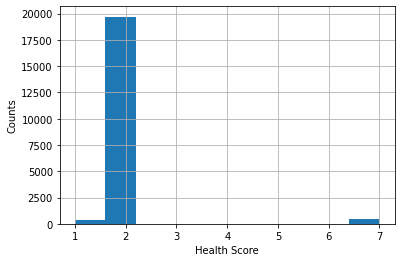

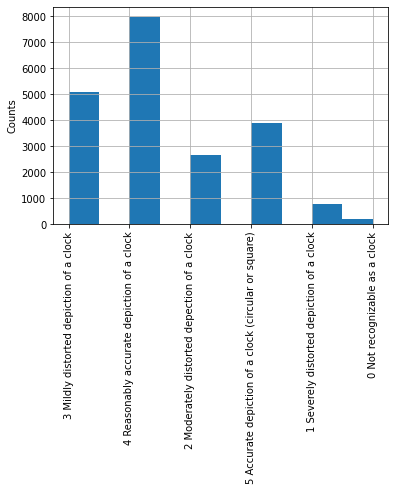

In [ ]:
# Check balance of dataset
a = rounds_clean.hc1disescn9.hist() 
plt.xlabel("Health Score")
plt.ylabel("Counts")
plt.show(a) 
b = rounds_clean.cg1dclkdraw.hist()
b.tick_params(axis='x', labelrotation = 90)
plt.ylabel("Counts")
plt.show(b)

###Create Labels for the data. 

In [58]:
def create_labels(rounds_clean):
  """Create labels: label 0 = pre-dementia, 1 = post-dementia, 2 = normal
  Create Normal Label for all entries, base case, then assign value 
  of 1 to 1's and 7's"""
  
  df = rounds_clean
  
  # Assign label of 2 or 1
  df['label'] = [2 if x == 2 else 1 for x in df['hc1disescn9']]

  # Changing Round 1-3
  for rounds in df['round'].unique()[:-1]:
    round_val = rounds

    round_post = df[df['round'] == (round_val + 1)]
    # assign label value of 0 to the previous round where diagnosis changed from a 2.0 to 1.0
    # diagnoses value of 7 corresponds to previous round value of 1, label stays a 1 

    post1 = round_post[round_post['hc1disescn9'] == 1]
    df.loc[(df['round'] == round_val) & df['spid'].isin(post1['spid']), 'label'] = 0
  
  return df

 
   
rounds_labeled = create_labels(rounds_clean)  

In [59]:
#@title test code
rounds_labeled[(rounds_labeled['hc1disescn9'] == 2) & (rounds_labeled['label'] == 0)]
rounds_labeled[rounds_labeled['spid'] == '10007575']

,spid,cg1dclkdraw,hc1disescn9,round,label
5034,10007575,1 Severely distorted depiction of a clock,2.0,1,2
4316,10007575,2 Moderately distorted depection of a clock,2.0,2,2
5102,10007575,5 Accurate depiction of a clock (circular or s...,2.0,3,0
4172,10007575,4 Reasonably accurate depiction of a clock,1.0,4,1


In [ ]:
#@title test code
#Checking for 
#rounds1_10.reset_index(inplace = True)
#rounds1_10.drop(columns=["index","cg1dclkdraw"], inplace = True)
#ids = rounds1_10[rounds1_10['hc1disescn9'] == 2]['spid'].values
#stop = 0

#for id in ids:
  #print(rounds1_10.loc[rounds1_10['spid'] == id])
  #stop +=1
  #if stop == 10:
    #break




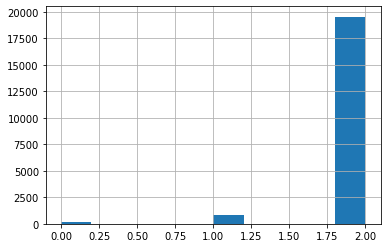

In [25]:
# Look at distribution of labels
import matplotlib.pyplot as plt

rounds_labeled.label.hist() #Highly unbalanced dataset - good case for generating synthetic data to rebalance

### Get Individual participant IDs per round
Could be useful for pulling in exact images per round

In [60]:
def get_ids(df):
  """ Creates dictionary of IDs per round"""

  id_dict = {}
  for val in df['round'].unique():
    id_dict[val] = df[df['round'] == val]['spid'].values
  return id_dict

id_rounds = get_ids(rounds_labeled)
id_rounds

{1: <StringArray>
 ['10000003', '10000004', '10000005', '10000006', '10000008', '10000010',
  '10000016', '10000017', '10000019', '10000020',
  ...
  '10012395', '10012398', '10012399', '10012400', '10012401', '10012402',
  '10012406', '10012407', '10012410', '10012411']
 Length: 6913, dtype: string, 2: <StringArray>
 ['10000003', '10000007', '10000008', '10000010', '10000017', '10000019',
  '10000020', '10000021', '10000022', '10000024',
  ...
  '10012382', '10012384', '10012388', '10012394', '10012395', '10012399',
  '10012400', '10012406', '10012407', '10012411']
 Length: 5501, dtype: string, 3: <StringArray>
 ['10001875', '10005977', '10002720', '10004997', '10008945', '10012329',
  '10004064', '10001846', '10005642', '10009717',
  ...
  '10003406', '10007851', '10012277', '10002122', '10005469', '10011980',
  '10003785', '10004106', '10007223', '10011851']
 Length: 4455, dtype: string, 4: <StringArray>
 ['10001875', '10002720', '10004997', '10012329', '10004064', '10001846',
  '10

In [62]:
id_rounds[1][0]

'10000003'

###Loading Image Data from AWS S3 Bucket
Testing basic function of getting data - will need to set up datastream

In [79]:
def get_images_test():
  counter = 0
  store_images = []

  for id, array in id_rounds.items(): 
    for value in array:
      if counter < 5:
      
        url = 'https://clockimages.s3.us-west-1.amazonaws.com/NHATS_R'+str(id)+'_ClockDrawings/'+value+'.tif'

        response = requests.get(url)#, stream = True)
        f = io.BytesIO(response.content)  
        im = Image.open(f)
        imarray = np.logical_not(np.array(im)).astype(int)
        viz_image(imarray, im)
        store_images.append(imarray)
        counter+=1

  return store_images



shape:  (3312, 2560)


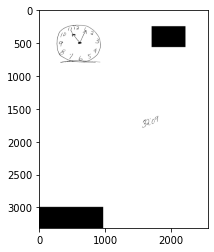

shape:  (3312, 2560)


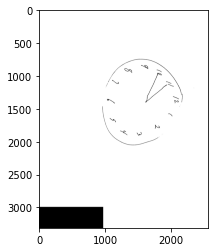

shape:  (3312, 2560)


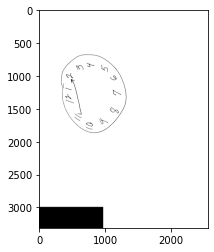

shape:  (3312, 2560)


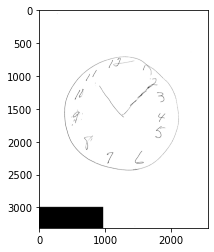

shape:  (3312, 2560)


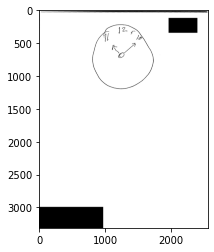

In [87]:
def viz_image(image, image_bool):
  print("shape: ", image.shape)

  # revert
  im2 = Image.fromarray(np.array(image_bool))
  plt.imshow(im2)
  plt.show()
 

image_array = get_images_test()